# Channel Estimation using ML

In [2]:
# Importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Implementing QPSK modulator

def qpsk_modulate(bits):

    """
    Maps input bits to normalized QPSK complex symbols using gray coding.
    00 -> (-1 - j)/√2
    01 -> (-1 + j)/√2
    11 -> (1 + j)/√2
    10 -> (1 - j)/√2 
    """

    # Reshaping the bitstream into rows of 2 bits (1 symbol per row) (-1 figures out the number of rows, cols=2)
    bits = bits.reshape(-1, 2)

    # Mapping first bit in each pair to in-phase component (I): 0 → -1, 1 → +1
    I = 2 * bits[:, 0] - 1

    # Map second bit in each pair to quadrature component (Q): 0 → -1, 1 → +1
    Q = 2 * bits[:, 1] - 1

    # Combine I and Q into complex symbols: I + jQ
    symbols = I + 1j * Q

    # Normalize the energy to keep unit average power and return the symbols
    return symbols / np.sqrt(2)


In [5]:
# Generating the dataset

def generate_dataset(num_samples=10000, snr_dB=10):

    """
    Generates a dataset for ML-based channel estimation using QPSK with Rayleigh fading and AWGN.
    """

    # Generate random bitstream (each QPSK symbol needs 2 bits)
    bits = np.random.randint(0, 2, size=(num_samples * 2,))

    # Modulate bits to QPSK complex symbols
    symbols = qpsk_modulate(bits)

    # Generate Rayleigh fading channel coefficients (complex Gaussian: h ~ CN(0,1))
    # randn: Gives a number from standard normal distribution.
    h = (np.random.randn(num_samples) + 1j * np.random.randn(num_samples)) / np.sqrt(2)

    # Compute noise power from SNR in dB
    noise_power = 10 ** (-snr_dB / 10)

    # Generate complex AWGN noise (independent real & imag parts)
    # Std Dev : np.sqrt(noise_power / 2), Variance : noise_power
    noise = np.sqrt(noise_power / 2) * (np.random.randn(num_samples) + 1j * np.random.randn(num_samples))

    # Received signal: y = h * x + noise
    y = h * symbols + noise

    # Input features for ML: concatenate real and imag parts of transmitted and received symbols
    X = np.column_stack((np.real(symbols), np.imag(symbols), np.real(y), np.imag(y)))

    # Output Labels for ML: real and imaginary parts of the channel h
    y_labels = np.column_stack((np.real(h), np.imag(h)))

    return X, y_labels


Input shape: (10000, 4)
Label shape: (10000, 2)


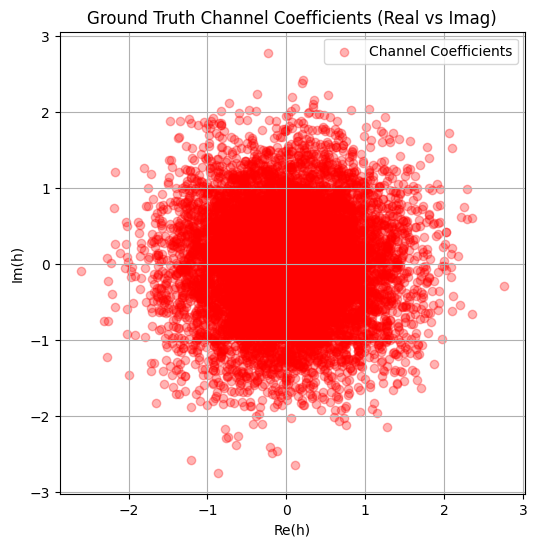

In [6]:
# Visualizing the dataset

X, y = generate_dataset()

print("Input shape:", X.shape)
print("Label shape:", y.shape)

# Plot
plt.figure(figsize=(6, 6)) # 6 inches wide and 6 inches tall (square)
plt.scatter(y[:, 0], y[:, 1], alpha=0.3, label='Channel Coefficients',c='red') # y[:, 0] - Real, y[:, 1] - Img
plt.title("Ground Truth Channel Coefficients (Real vs Imag)") 
plt.xlabel("Re(h)")
plt.ylabel("Im(h)")
plt.grid(True)
plt.legend()
plt.show()

# The plot will look like a circular cloud of points centered at (0, 0) -> Known property of Rayleigh fading

In [ ]:
# Loading and Splitting the dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler      # To normailze inputs

# Loading the dataset
X, y_labels = generate_dataset(num_samples=10000, snr_dB=10)

# Spliting into training data (80% or 0.8) and test data (20% or 0.2)
# Fixed random seed 42 so that every time we run this, the split is the same
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

# Normalizing features (optional but improves training) (subtracting mean and dividing by std dev)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit_transform learns the mean/std from training data and applies scaling
print("Mean used for scaling:", scaler.mean_) # Printing the mean value found
print("Standard deviation used for scaling:", scaler.scale_) # Printing the std dev value found
X_test = scaler.transform(X_test) # We only transform test data (no fitting) using the same mean/std from training.


Mean used for scaling: [ 0.00548008 -0.00371231  0.00311639  0.00047546]
Standard deviation used for scaling: [0.70708555 0.70709704 0.74110797 0.74835339]


In [8]:
# Building the Model using Neural Networks

from tensorflow.keras.models import Sequential   # Sequential: It stacks the layers
from tensorflow.keras.layers import Dense        # Dense: This creates fully connected layers
from tensorflow.keras.optimizers import Adam     # Adam: An optimizer that adjusts how the model learns

# Step 1: Define the model
model = Sequential([

    # First Hidden layer: 4 features or inputs, 32 neurons, ReLU activation (Non Linear)
    Dense(32, activation='relu', input_shape=(4,)),  # Relu: o/p = i/p if i/p>=0 else o/p = 0
    
    # Second Hidden layer: 16 neurons, ReLU activation
    Dense(16, activation='relu'),  # Inputs from 32 inputs in previous layer
    
    # Output layer: 2 neurons (Re(h), Im(h))
    Dense(2, activation='linear')  # Linear: No activation, just outputs the raw value (It is a regression task).
])

# Step 2: Compiling the model - Preparing the model for training

# - Adam used because it is better than gradient descent
# - Default Learning Rate (alpha) = 0.001 (good starting point)
# - Loss is what the model actually tries to minimize while learning
# - Loss: MSE (mean squared error, since this is regression)
# - Metrics are what we care about seeing during training to understand performance (Easier to interpret than MSE)
# - MAE: Mean Absolute Error just tells us average prediction error. (No squaring unlike MSE, just take mod)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Step 3: Training the model

history = model.fit(                    # Training happens due to fit
    X_train, y_train,                   # The training data and the ground truth labels (Re(h), Im(h))
    validation_data=(X_test, y_test),   # The model will check how well it does on unseen data after each epoch
    epochs=20,                          # The model will go through the entire dataset 20 times to improve
    batch_size=64,                      # The model trains in mini-batches of 64 samples at a time
    verbose=1                           # Shows a progress bar and loss/MAE per epoch
)


c:\Users\Madhulika Banerjee\OneDrive\Desktop\ML+Wireless_Projects\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4711 - mae: 0.5302 - val_loss: 0.2078 - val_mae: 0.3435
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1688 - mae: 0.3040 - val_loss: 0.0929 - val_mae: 0.2300
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0803 - mae: 0.2174 - val_loss: 0.0681 - val_mae: 0.2016
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0639 - mae: 0.1972 - val_loss: 0.0605 - val_mae: 0.1923
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0568 - mae: 0.1866 - val_loss: 0.0563 - val_mae: 0.1864
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0532 - mae: 0.1828 - val_loss: 0.0544 - val_mae: 0.1841
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508 - mae: 0.1792 - val_loss: 0.0524 - val_mae: 0.1814
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0505 - mae: 0.1791 - val_loss: 0.0520 - val_mae: 0.1811
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

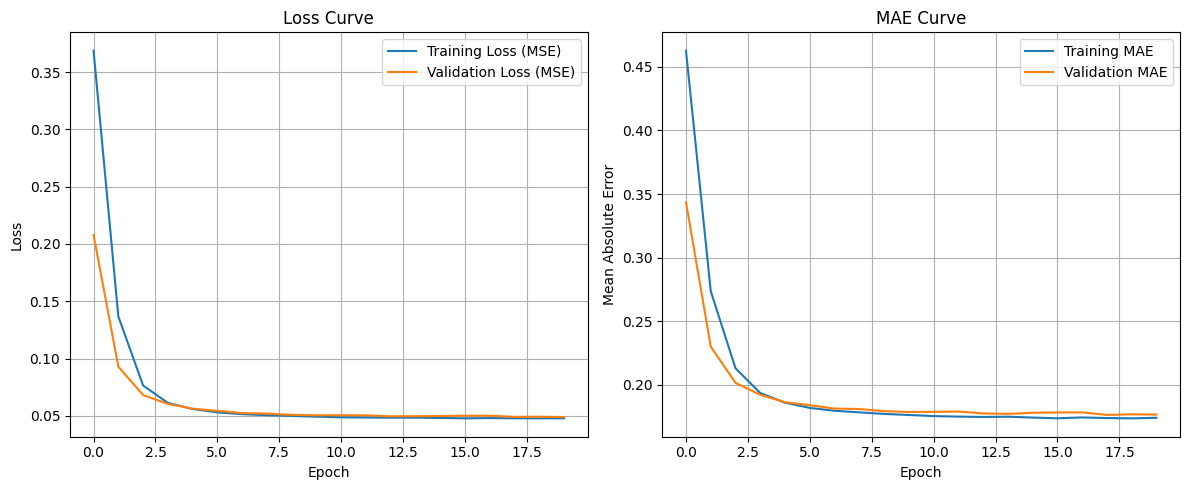

In [ ]:
# Visualizing Loss vs MAE

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# MSE Loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, this is the 1st plot
plt.plot(history.history['loss'], label='Training Loss (MSE)') 
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# 1st history: Our variable name
# 2nd history: The Keras object returned by .fit() also happens to have an attribute called history

# MAE
plt.subplot(1, 2, 2) # 1 row, 2 columns, this is the 2nd plot
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


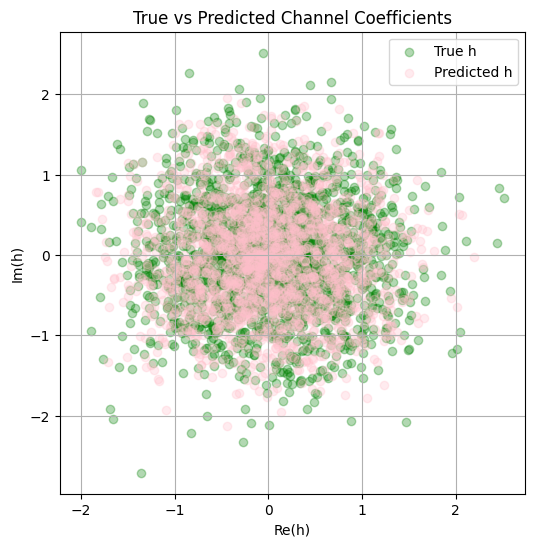

In [10]:
# Visualizing predicted vs actual channel coefficients

# Predicting on test data
y_pred = model.predict(X_test)

# Scatter plot of predicted vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test[:, 0], y_test[:, 1], alpha=0.3, color='green', label='True h') # Actual h
plt.scatter(y_pred[:, 0], y_pred[:, 1], alpha=0.3, color='pink', label='Predicted h') # Predicted h
plt.xlabel('Re(h)')
plt.ylabel('Im(h)')
plt.title("True vs Predicted Channel Coefficients")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluating the performance

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculating metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared Score (R²): {r2:.4f}")


Mean Absolute Error (MAE): 0.1767
Mean Squared Error (MSE): 0.0489
R-squared Score (R²): 0.9048


In [13]:
# Saving the trained model to a file

model.save("QPSK_Channel_Estimator.keras")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Loading the model later

# from tensorflow.keras.models import load_model
# loaded_model = load_model("qpsk_channel_estimator.keras")